In [4]:
!pip install earthengine-api
import ee
from google.colab import auth

In [5]:
import ee
import folium
import geemap

auth.authenticate_user()
ee.Initialize(project='ee-twishaahuja')
mangrovee = ee.FeatureCollection('projects/ee-twishaahuja/assets/mumbai')

In [6]:
def mask_s2_clouds(image):
    qa = image.select('QA60')

    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))

    return image.updateMask(mask).divide(10000)

In [7]:
def calculate_mangrove_stats_for_year(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    dataset = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(start_date, end_date)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                .map(mask_s2_clouds))

    ndvi = dataset.mean().normalizedDifference(['B8', 'B4']).rename('NDVI')
    mangrove_mask = ndvi.gt(0.4)  # NDVI threshold for mangroves
    mangroves = ndvi.updateMask(mangrove_mask)

    mangroves_within_boundary = mangroves.clip(mangrovee)

    mangrove_area = mangroves_within_boundary.multiply(ee.Image.pixelArea())

    # Sum the mangrove area (in square meters)
    total_area = mangrove_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mangrovee.geometry(),
        scale=10,
        maxPixels=1e13
    )

    # Convert area from square meters to square kilometers
    area_km2 = ee.Number(total_area.get('NDVI')).divide(1e6)

    # Carbon sequestration estimation based on area
    carbon_density = 102 * 1000 * 100  # 102 tons/hectare = 102,000 kg/hectare = 10,200,000 kg/km²
    total_carbon_kg = area_km2.multiply(carbon_density)

    return ee.Dictionary({
        'year': year,
        'areaKm2': area_km2,
        'carbonKg': total_carbon_kg
    })


In [8]:
years = ee.List.sequence(2019, 2023)
yearly_mangrove_stats = years.map(lambda year: calculate_mangrove_stats_for_year(ee.Number(year)))

total_stats = yearly_mangrove_stats.iterate(lambda stat, acc: (
    ee.Dictionary(acc).combine(ee.Dictionary(stat).select(['areaKm2', 'carbonKg']))
), ee.Dictionary({'areaKm2': 0, 'carbonKg': 0}))

total_area = ee.Dictionary(total_stats).get('areaKm2')
total_carbon = ee.Dictionary(total_stats).get('carbonKg')

# print('Total Mangrove Area (2019-2023) in km²:', total_area.getInfo())
# print('Total Carbon Sequestration (2019-2023) in kg:', total_carbon.getInfo())

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

dataset = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate('2019-01-01', '2024-10-15')
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
            .map(mask_s2_clouds))

ndvi = dataset.mean().normalizedDifference(['B8', 'B4']).rename('NDVI') # NDVI = (B8 - B4)/(B8 + B4)

mangrove_mask = ndvi.gt(0.4)  # NDVI threshold for mangroves
mangroves = ndvi.updateMask(mangrove_mask)

mangroves_within_boundary = mangroves.clip(mangrovee)

Map = geemap.Map()
Map.addLayer(mangroves_within_boundary, {'min': 0, 'max': 1, 'palette': ['lightgreen', 'darkgreen']}, 'Mangrove NDVI (Within Boundary)')

# Carbon sequestration estimation:
carbon_density = 102 * 1000 * 100  # 102 tons/hectare = 102,000 kg/hectare = 10,200,000 kg/km²

# Calculate the area of detected mangroves (within the Mumbai boundary) in square meters
mangrove_area = mangroves_within_boundary.multiply(ee.Image.pixelArea())

# Sum the mangrove area (in square meters) for carbon estimation, within the boundary
total_area_within_boundary = mangrove_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=mangrovee.geometry(),
    scale=10,
    maxPixels=1e13
)

# Convert the area from square meters to square kilometers (1 km² = 1,000,000 m²)
area_square_km = ee.Number(total_area_within_boundary.get('NDVI')).divide(1e6)

# Estimate total carbon stored (in kilograms) within the boundary
total_carbon_kg = area_square_km.multiply(carbon_density)

print('Total Mangrove Area (square kilometers) within Mumbai boundary:', area_square_km.getInfo())
print('Estimated Carbon Sequestration (kilograms) within Mumbai boundary:', total_carbon_kg.getInfo())

mqi = ndvi.select('NDVI').gt(0.4).multiply(3)
mqi = mqi.add(ndvi.select('NDVI').gt(0.2).And(ndvi.select('NDVI').lte(0.4)).multiply(2))
mqi = mqi.add(ndvi.select('NDVI').lte(0.2).multiply(1))

mqiVisParams = {
    'min': 1,
    'max': 3,
    'palette': ['red', 'yellow', 'green']
}
mqi_clipped = mqi.clip(mangrovee)
Map.addLayer(mqi_clipped, mqiVisParams, 'Mangrove Quality Index (MQI)')


Map.setCenter(72.8777, 19.0760, 10)
Map

Total Mangrove Area (square kilometers) within Mumbai boundary: 182.50504142452843
Estimated Carbon Sequestration (kilograms) within Mumbai boundary: 1861551422.53019


Map(center=[19.076, 72.8777], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [9]:
import matplotlib.pyplot as plt
import numpy as np


In [10]:
yearly_mangrove_stats_list = yearly_mangrove_stats.getInfo()

years_list = [stat['year'] for stat in yearly_mangrove_stats_list]
area_list = [stat['areaKm2'] for stat in yearly_mangrove_stats_list]
carbon_list = [stat['carbonKg'] for stat in yearly_mangrove_stats_list]


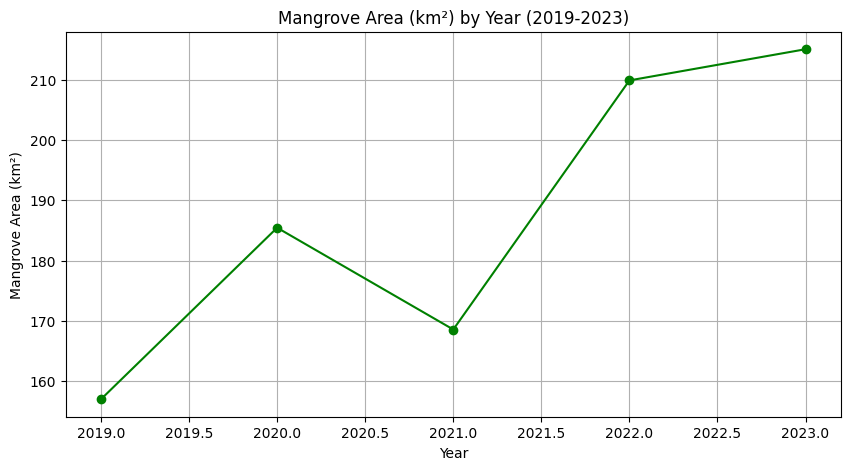

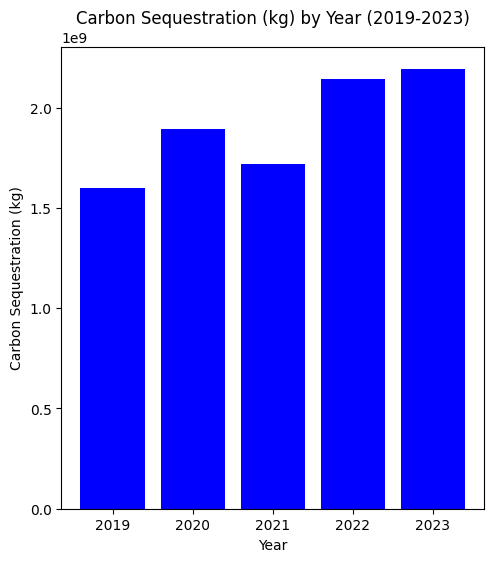

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(years_list, area_list, color='green', marker='o')
plt.title('Mangrove Area (km²) by Year (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Mangrove Area (km²)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.bar(years_list, carbon_list, color='blue')
plt.title('Carbon Sequestration (kg) by Year (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Carbon Sequestration (kg)')
plt.xticks(years_list)
plt.show()

Temporal Change Analysis

In [15]:
# Function to mask clouds in Sentinel-2 imagery
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

# Function to calculate NDVI for a given year
def calculateYearlyNDVI(year):
    startDate = ee.Date.fromYMD(year, 1, 1)
    endDate = ee.Date.fromYMD(year, 12, 31)

    dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                .filterDate(startDate, endDate) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                .map(maskS2clouds)

    ndvi = dataset.mean().normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi.set('year', year)

# Define the years of interest
years = ee.List.sequence(2019, 2023)

# Map over the years and calculate NDVI for each year
yearlyNDVI = years.map(lambda year: calculateYearlyNDVI(ee.Number(year)))

# Create an image collection from the NDVI results
ndviCollection = ee.ImageCollection(yearlyNDVI)

# Define visualization parameters
ndviVisParams = {
    'min': 0,
    'max': 1,
    'palette': ['yellow', 'green']
}

# Select the area of interest (your mangrove region)
mangrovee = ee.Geometry.Polygon(
    [[[72.7742, 19.2544], [72.7742, 18.9360], [73.0367, 18.9360], [73.0367, 19.2544], [72.7742, 19.2544]]]
)

# Add the NDVI for each year to the map and export each image
import os
gif_dir = os.path.join(os.path.expanduser('~'), 'mangrove_ndvi')
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

for year in range(2019, 2024):
    ndviImage = ndviCollection.filter(ee.Filter.eq('year', year)).first().clip(mangrovee)

    # Export each year's NDVI as an image
    filename = os.path.join(gif_dir, f'ndvi_{year}.png')
    geemap.ee_export_image(ndviImage, filename=filename, scale=10, region=mangrovee, file_per_band=False)

print(f"Images saved to {gif_dir}")

# Check the files in the gif_dir
files_in_dir = os.listdir(gif_dir)
print(f"Files in {gif_dir}: {files_in_dir}")


The filename must end with .tif
The filename must end with .tif
The filename must end with .tif
The filename must end with .tif
The filename must end with .tif
Images saved to /root/mangrove_ndvi
Files in /root/mangrove_ndvi: []


In [25]:
import os
import geemap

# Create a directory to store the exported GeoTIFF files
tif_dir = os.path.join(os.path.expanduser('~'), 'mangrove_ndvi_tif')
if not os.path.exists(tif_dir):
    os.makedirs(tif_dir)

# Export NDVI images for each year as GeoTIFFs
for year in range(2019, 2024):
    print(f"Processing NDVI image for the year: {year}")

    try:
        ndviImage = ndviCollection.filter(ee.Filter.eq('year', year)).first().clip(mangrovee)
        if ndviImage is None:
            print(f"No NDVI image found for the year {year}. Skipping...")
            continue

        # Export each year's NDVI as a GeoTIFF
        filename = os.path.join(tif_dir, f'ndvi_{year}.tif')

        print(f"Exporting {filename}")

        geemap.ee_export_image(
          ndviImage,
          filename=filename,
          scale=30,  # Increase scale to reduce size
          region=mangrovee,
          file_per_band=False
        )


        print(f"Successfully exported {filename}")

    except Exception as e:
        print(f"Error exporting NDVI image for the year {year}: {e}")


Processing NDVI image for the year: 2019
Exporting /root/mangrove_ndvi_tif/ndvi_2019.tif
Generating URL ...
Please wait ...
Data downloaded to /root/mangrove_ndvi_tif/ndvi_2019.tif
Successfully exported /root/mangrove_ndvi_tif/ndvi_2019.tif
Processing NDVI image for the year: 2020
Exporting /root/mangrove_ndvi_tif/ndvi_2020.tif
Generating URL ...
Please wait ...
Data downloaded to /root/mangrove_ndvi_tif/ndvi_2020.tif
Successfully exported /root/mangrove_ndvi_tif/ndvi_2020.tif
Processing NDVI image for the year: 2021
Exporting /root/mangrove_ndvi_tif/ndvi_2021.tif
Generating URL ...
Please wait ...
Data downloaded to /root/mangrove_ndvi_tif/ndvi_2021.tif
Successfully exported /root/mangrove_ndvi_tif/ndvi_2021.tif
Processing NDVI image for the year: 2022
Exporting /root/mangrove_ndvi_tif/ndvi_2022.tif
Generating URL ...
Please wait ...
Data downloaded to /root/mangrove_ndvi_tif/ndvi_2022.tif
Successfully exported /root/mangrove_ndvi_tif/ndvi_2022.tif
Processing NDVI image for the year: 

In [30]:
import os
import imageio

# Set the directory where the NDVI images are stored
tif_dir = os.path.join(os.path.expanduser('~'), 'mangrove_ndvi_tif')

# List to store the NDVI images
ndvi_images = []

# Load each NDVI image and append to the list
for year in range(2019, 2024):
    filename = os.path.join(tif_dir, f'ndvi_{year}.tif')

    if os.path.exists(filename):
        ndvi_images.append(filename)
    else:
        print(f"Image for {year} not found.")


In [37]:
import os
import imageio
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Set the directory where the NDVI images are stored
tif_dir = os.path.join(os.path.expanduser('~'), 'mangrove_ndvi_tif')

# List to store the NDVI images
ndvi_images = []

# Load each NDVI image and apply color mapping
for year in range(2019, 2024):
    filename = os.path.join(tif_dir, f'ndvi_{year}.tif')

    if os.path.exists(filename):
        with rasterio.open(filename) as src:
            ndvi_data = src.read(1)  # Read the first band

            # Normalize NDVI values to the range [0, 1]
            ndvi_normalized = (ndvi_data + 1) / 2

            # Create a color map
            colormap = plt.get_cmap('RdYlGn')  # You can choose a different colormap

            # Apply the colormap to NDVI values
            colored_image = (colormap(ndvi_normalized)[:, :, :3] * 255).astype(np.uint8)  # RGB

            # Append the colored image to the list
            ndvi_images.append(colored_image)
    else:
        print(f"Image for {year} not found.")

# Define the output filename for the GIF
gif_filename = os.path.join(tif_dir, 'mangrove_ndvi_changes.gif')

# Create the GIF
imageio.mimsave(gif_filename, ndvi_images, duration=1)  # duration=1s between frames
print(f"GIF saved to {gif_filename}")


GIF saved to /root/mangrove_ndvi_tif/mangrove_ndvi_changes.gif


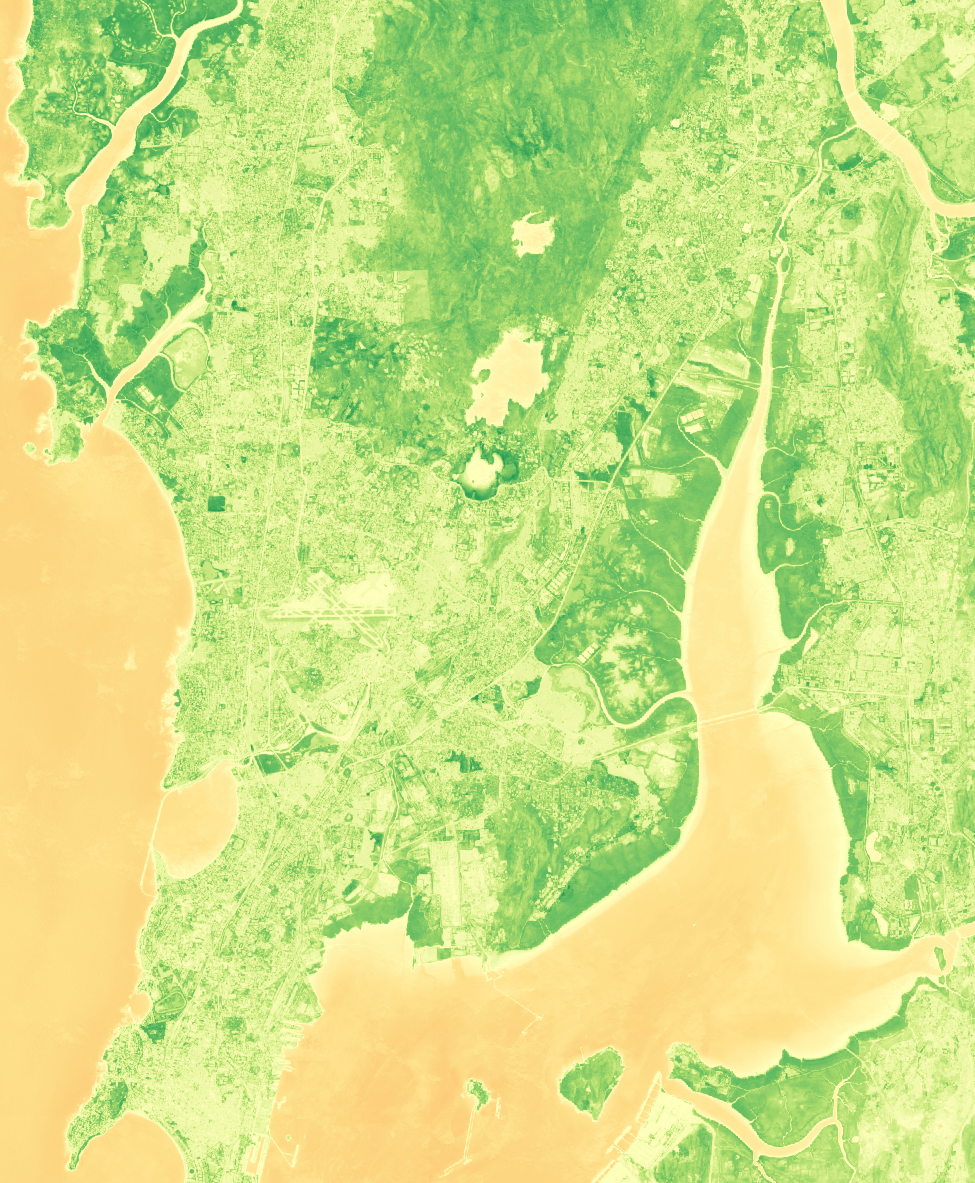

In [40]:
from IPython.display import Image, display

# Define the path to your GIF file
gif_filename = os.path.join(tif_dir, 'mangrove_ndvi_changes.gif')

# Display the GIF
display(Image(filename=gif_filename))
